# Gaussian Mixtures: K-Means and Expectation Maximization
Created by: Juneyong Yang\
Contact: laoconeth@kaist.ac.kr

# Preliminaries

앞으로 사용하게 될 library들 및 함수들이 선언된 곳입니다.


In [1]:
import sys
print(sys.version)

3.6.2 (default, May 30 2018, 21:53:12) 
[GCC 5.4.0 20160609]


In [2]:
import numpy as np
import sklearn.covariance
import sklearn.mixture
import sklearn.cluster
import torch
import math
import os
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def plot_data(X, y, n_clusters):
    # plot data
    plt.figure()

    for idx in range(n_clusters):
        plt.scatter(X[y == idx, 0], X[y == idx, 1],
                    label='{0}'.format(idx))


    ax = plt.gca()
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.legend()
    plt.show()
    plt.close()


# Introduction
오늘 강의에서 배운 개념들 중 Gaussian Mixture 모델과 K-Means, Expectation Maximization을 이용한 latent variable inference를 실습할 것입니다. 학습 단계는 다음과 같습니다.
- 무작위 parameter들로 설정된 가공의 gaussian mixture를 만들어 보고, 이로부터 인공 데이터셋을 생성해 보기
- K-means clustering을 구현해 보고, 인공 데이터에 사용해 보기
- Expectation Maximization을 구현해 보고, 인공 데이터에 사용해 보기

# Gaussian Mixtures
Mixture model은 데이터 $x$의 분포가 계층(hierarchy)을 가진다고 보는 분포입니다. 즉, 먼저 우리가 모르는 어떠한 random variable $z$가 확률적으로 생성됩니다. 그리고 이 $z$에 conditioning 된 분포로부터 $x$가 샘플되는 형식입니다. 다시 말하면, 사실 우리가 모르는 $z$라는 변수가 있어서,
$$
p(x,z) = p(z)p(x|z)
$$
$$
z \sim p(z)
$$
$$
x \sim p(x|z)
$$
와 같이 $z$가 샘플되고, 그것에 condition되어 $x$가 생성되는 꼴입니다.

Gaussian mixture는 위와 같은 mixture model에서, p(z)가 Categorical distribution이고, p(x|z)가 gaussian distribution인 모델입니다. 즉, 
$$
z \sim Cat(\boldsymbol{\pi})
$$
$$
x \sim \mathcal{N}(\mu_{z}, \Sigma_{z})
$$

<p align="center">
  <img src="gmm_3d.png" alt="gmm with 2 clusters."/>
</p>

실습을 위해 인공 GMM 데이터를 생성합니다. 먼저 클러스터의 개수를 정하고, 그 개수만큼 클러스터 평균(중심)을 샘플링합니다. 그 다음, 클러스터 별로 각각 Covariance Matrix를 샘플링합니다. 샘플링한 parameter들을 사용하여 실제 data point들을 샘플링하여 데이터셋을 생성합니다.

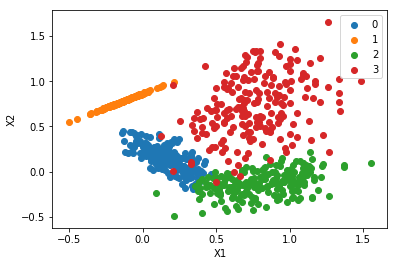

In [4]:
# Synthesize data

n_clusters = 4

mean_max = 3

X = []
y = []
true_mu_list = []
true_sigma_list = []

for idx in range(n_clusters):
    coord = (int(idx / int(n_clusters**(1/2))), idx % int(n_clusters**(1/2)))
    class_mean = np.random.multivariate_normal(coord, cov=(np.eye(2)*0.03))
    true_mu_list.append(class_mean)
    A = np.random.uniform(-1, 1, (2, 2)) * 0.3
    real_cov = np.dot(A,A.transpose())
    true_sigma_list.append(real_cov)
    
    X.append(np.random.multivariate_normal(mean=class_mean, cov=real_cov, size=200))
    y.append(np.full(200, idx))
    
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

y_true = y

true_mu_list = np.stack(true_mu_list, axis=0)
true_sigma_list = np.stack(true_sigma_list, axis=0)

y_onehot = np.zeros((X.shape[0], n_clusters))
y_onehot[np.arange(X.shape[0]), y] = 1

# plot data
plot_data(X, y_true, n_clusters)

# K-Means

K-means clustering 알고리즘은 간단하고 직관적인 알고리즘입니다. 이 알고리즘을 사용하면, 데이터로부터 K개의 cluster를 얻게 됩니다. 이 때, **K는 hyperparameter**로써 사람이 임의로 정해주는 값입니다. Cluster의 갯수까지 자동으로 정하는 알고리즘들은 더 복잡합니다. K-mean는 다음과 같은 step들로 동작합니다.
## 1) Initialization
K개 cluster들의 mean을 초기화합니다. 일반적으로 사용되는 간단한 방법은 K개의 point들을 무작위로 뽑은 후, 각 point가 각 cluster의 중심이라고 설정하는 것입니다.

## 2) Cluster assignment
데이터 $\left\{\mathbf{x}_{1}, \mathbf{x}_{2}, \ \mathbf{x}_{N}\right\}$ 을 받고, 모든 데이터 포인트를 K개의 그룹에 배정합니다.
클러스터 소속은 현재 데이터 포인트로부터 어떤 클러스터 중심이 가장 가까운지를 비교해본 후, 가장 가까운 클러스터에 배정합니다. 이때, "가까움" 은 유클리드 공간에서의 거리를 사용합니다. 즉, 
$$ r_{nk}=\begin{cases}
    1, & {\arg\min_{j} \|\mathbf{x}_{n} - \boldsymbol{\mu}_{j}\|_{2}^{2}}\\
    0, & \text{otherwise.}
  \end{cases}$$
  
## 3) Cluster mean update
위에서와 같이 클러스터 소속을 배정한 후, 배정한 소속이 마치 진실이라고 가정하고 클러스터 중심을 계산합니다. 즉,
$$
\mu_{k}^{new} = \frac{\sum_{n}^{N} r_{nk}\mathbf{x}_{n}}{\sum_{n}^{N} r_{nk}}
$$

## 4) Termination
위의 2가지 스텝을 반복하다 보면, 어느 순간부터는 더 반복해도 클러스터 배정이 바뀌지 않습니다. 클러스터 배정이 바뀌지 않는다면 클러스터 중심도 움직이지 않으므로, 알고리즘이 수렴한 것입니다. 따라서 종료할 수 있습니다.

## Remarks
K-means 알고리즘에서는 cluster mean 만이 중요합니다. 즉, gaussian mixture 모델을 fitting하는 알고리즘이지만, mixing distribution이 uniform이고, 모든 cluster의 covariance matrix가 identity의 상수배인 것과 같은 상황이 됩니다. 따라서, 데이터가 이러한 조건에 부합하지 않는다면 잘못된 클러스터를 recover하게 됩니다.

## Coding

In [5]:
def kMeans(X, n_clusters, max_iter=10):

    # Initialize cluster means
    cluster_means = X[np.random.choice(np.arange(len(X)), n_clusters), :]

    for i in range(max_iter):
        # Re-assign clusters
        y = np.array([np.argmin([np.dot(x_i-mu_k, x_i-mu_k) for mu_k in cluster_means]) for x_i in X])
        # If the assignments didn't change, exit
        if i != 0:
            if np.array_equal(y,y_old):
                break
        y_old = y
        # Recalculate cluster means
        cluster_means = [X[y == k].mean(axis = 0) for k in range(n_clusters)]
         
    cluster_means = np.array(cluster_means)
    return cluster_means , y

In [6]:
mu_kmeans, kmeans_result = kMeans(X, n_clusters=n_clusters)

Plot을 통해 결과를 확인합니다. Class의 이름은 임의로 배정되므로(컴퓨터가 clustering은 할 수 있지만, 이 cluster가 어떤 의미인지는 알 수 없음), 색깔이 다를 수 있습니다.

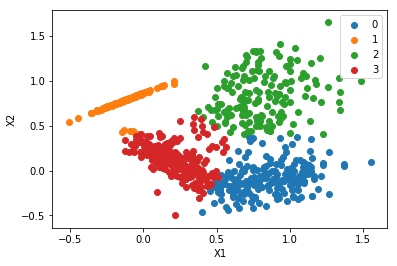

In [7]:
plot_data(X, kmeans_result, n_clusters)

클러스터들의 true mean, covariance와 EM 알고리즘으로 추론한 mean, covariance 값들을 비교해 봅니다.

In [8]:
print("Cluster means:")
print(mu_kmeans)
print(true_mu_list)

Cluster means:
[[ 0.85018459 -0.09037127]
 [-0.12819083  0.77124762]
 [ 0.81141765  0.84238309]
 [ 0.21017731  0.13769772]]
[[ 0.17390871  0.14259868]
 [-0.14099067  0.77402503]
 [ 0.8356521  -0.11299532]
 [ 0.73054665  0.7313819 ]]


우리의 코드가 잘 동작했는지 보기 위해 Scikit-Learn에 미리 구현되어 있는 K-mean 알고리즘을 사용합니다.

In [9]:
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, init='random',  random_state=0).fit_predict(X)

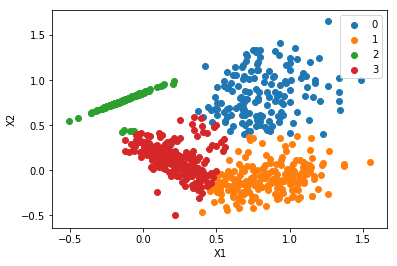

In [10]:
plot_data(X, kmeans, n_clusters)

# Expectation Maximization

## EM Introduction

GMM의 parameter들을 계산하기 위해 maximum likelihood estimation을 한다고 가정하면, GMM의 likelihood는 다음과 같이 주어집니다.
$$
p(\mathbf{x}|\pi, \mu, \Sigma) = \prod_{n=1}^{N}(\sum_{k=1}^{K}\pi_{k} \mathcal{N}(x_{n}|\mu_{k}, \Sigma_{k}))
$$
하지만 안쪽의 summation 때문에, log likelihood를 maximize하기가 어려워집니다. 우리는 이를 우회하기 위하여 EM 알고리즘을 사용합니다.

EM 알고리즘은 우리가 latent variable $z$를 마치 알고 있다는 듯이 행동함으로써 위의 문제를 해결합니다. (실제로는 모르지만) $z$를 알고 있다고 하면, likelihood는 다음과 같이 주어집니다.

$$
p(\mathbf{x}, \mathbf{z}|\pi, \mu, \Sigma) = \prod_{n=1}^{N}(\prod_{k=1}^{K}\pi_{k}^{z_{nk}} \mathcal{N}(x_{n}|\mu_{k}, \Sigma_{k})^{z_{nk}})
$$

이때, $z_{n,:}$는 data point $x_{n}$이 어떤 cluster 소속인지를 나타내는 one-hot code random variable 입니다. 즉, 만약 $x_{n}$이 3번 cluster 소속이라면, $z_{n,3} = 1$ 이고 $z_{n,k\neq3} = 0$ 입니다.

모든 것이 product로만 되어있기 때문에, log를 취하면 전부 summation으로 바뀌면서 다루기 쉬운 꼴이 됩니다. 하지만 실상은 $z$를 모르는 상황입니다. 이 상황을 타개하기 위하여 K-means와 유사하게 현재의 parameter들을 사용하여 $z$를 추정(E-step)하고, 추정한 $z$를 사용하여 다시 parameter들을 추정(M-step)하는 iterative process를 사용합니다.

## E-Step

E-Step에서는 추산된 클러스터들의 평균 $\mu_{k}$와 covariance matrix $\Sigma_{k}$들과 데이터 $x_{n}$을 사용하여, $x_{n}$이 과연 어떤 클러스터 소속일지 추론합니다. $x_{n}$이 클러스터 k에 속할 확률(responsibility) $r(z_{nk})$ 를 계산하는 것입니다. Bayes rule을 사용하여 다음과 같이 구할 수 있습니다.

$$
\begin{align} r(z_{nk}) &= p(z_{nk} = 1|x_{n}, \theta_{old}) \nonumber \\
&= \frac{p(z_{nk} = 1)p(x_{n}|z_{nk}=1)}{\sum_{j}^{K} p(z_{nj} = 1)p(x_{n}|z_{nj}=1)} \nonumber \\
&= \frac{\pi_{k}\mathcal{N}(x_{n}|\mu_{k}, \Sigma_{k})}{\sum_{j=1}^{K} \pi_{j}\mathcal{N}(x_{n}|\mu_{j}, \Sigma_{j})} \nonumber\\
\nonumber
\end{align}
$$

## M-Step

M-step에서는 E-step에서 추론한 responsibility를 진실이라고 믿고, 이로부터 Gaussian Mixture의 parameter들을 추정합니다.

$$
\pi_{k}^{new} = \frac{N_{k}}{N}
$$

$$
\mu_{k}^{new} = \frac{1}{{N_{k}}} \sum_{n}^{N} r(z_{nk})\mathbf{x}_{n}
$$

$$
\Sigma_{k}^{new} = \frac{1}{{N_{k}}} \sum_{n}^{N} r(z_{nk})(f(\mathbf{x}_{n}) - {\mu_{k}})(f(\mathbf{x}_{n}) - {\mu_{k}})^{T}
$$

## Termination
E-step과 M-step을 계속 반복합니다. Likelihood가 더이상 상승하지 않거나, parameter들의 수렴 추세가 일정 threshold 미만으로 떨어졌다면, 알고리즘을 종료합니다.

## Coding
위의 수식들을 코드로 옮깁니다. 다음과 같은 변수들을 사용합니다.
- X = (N, num_features)차원 numpy array
- y = (N, K)차원 numpy array
- r = (N, K)차원 numpy array
- pi = (K,)차원 numpy array
- mu = (K, num_features)차원 numpy array
- sigma = (K, num_features, num_features)차원 numpy array

In [11]:
def m_step(X, r):

    K = r.shape[1]
    N = r.shape[0]

    pi = np.sum(r, 0) / float(N)

    mu = []
    
    num_features = X.shape[1]
    
    mu = np.empty((K, int(num_features)))
    sigma = np.empty((K, int(num_features), int(num_features)))
    for k in range(K):
        # Fill in this part
        Nk = np.sum(r[:, k])
        mu[k] = np.sum(r[:, k:k+1] * X, 0) / Nk
        weighted_X = (X - mu[k]) * np.sqrt(r[:, k:k+1])
        sigma[k] = np.dot(weighted_X.T, weighted_X) / Nk

    return pi, mu, sigma

In [12]:
from scipy.stats import multivariate_normal
def e_step(pi, mu, sigma, X, y):
    
    N = X.shape[0]
    K = y.shape[1]
    
    r = np.zeros(y.shape)
    
    for i in range(N):
        evidence = 0
        for j in range(K):
            joint_likelihood = multivariate_normal.pdf(X[i, :], 
                                                       mu[j], 
                                                       sigma[j]) * pi[j]
            evidence += joint_likelihood
            r[i, j] = joint_likelihood
        r[i, :] /= evidence
        assert r[i, :].sum() - 1 < 1e-4
    return r

In [13]:
def log_likelihood(pi, mu, sigma, X, y):
    
    N = X.shape[0]
    K = y.shape[1]
    
    ll = 0
    for i in range(N):
        ll_per_sample = 0
        for j in range(K):
            likelihood = multivariate_normal.pdf(X[i, :], 
                                                 mu[j], 
                                                 sigma[j]) * pi[j]
            ll_per_sample += likelihood
        ll += np.log(ll_per_sample)
    return ll

In [14]:
# Initialize stuff for EM iteration

threshold=0.00001
max_iter=50

iter = 0
converged = False
old_pi = None
old_mu = None
old_sigma = None

# initialize assignments
r = kmeans
r = np.zeros((X.shape[0], n_clusters))
r[np.arange(X.shape[0]), kmeans] = 1



In [15]:
# Perform EM iteration

print("Iter\tlog-likelihood\tpi-diff\tmu-diff\tsigma-diff")
while not converged:     
    iter += 1

    # M-step
    (pi, mu, sigma) = m_step(X, r)        

    # E-step
    r = e_step(pi, mu, sigma, X, y_onehot)  

    # check likelihood
    log_L = log_likelihood(pi, mu, sigma, X, y_onehot)

    if old_pi is not None:
        pi_diff = np.sum(np.abs(pi - old_pi))
        mu_diff = np.sum(np.abs(mu - old_mu))
        sigma_diff = np.sum(np.abs(sigma - old_sigma))
        print(
            '{0} \t {1:.6f} \t{2:.6f}\t{3:.6f}\t{4:.6f}'.format(iter,
                                                            log_L,
                                                            pi_diff,
                                                            mu_diff,
                                                            sigma_diff))
        if (pi_diff < threshold
            and mu_diff < threshold
            and sigma_diff < threshold) or iter > max_iter:
            converged = True
    else:
        print('{0} \t {1:.6f}'.format(iter, log_L,))

    old_pi = pi
    old_mu = mu
    old_sigma = sigma

Iter	log-likelihood	pi-diff	mu-diff	sigma-diff
1 	 -167.861230
2 	 360.137512 	0.036895	0.106172	0.061737
3 	 387.974614 	0.027169	0.065419	0.034166
4 	 392.416990 	0.014074	0.033010	0.018973
5 	 393.187569 	0.007893	0.019219	0.010850
6 	 393.434912 	0.004662	0.012098	0.006906
7 	 393.531527 	0.002827	0.007774	0.004355
8 	 393.572017 	0.001755	0.005109	0.002795
9 	 393.589717 	0.001105	0.003417	0.001827
10 	 393.597724 	0.000729	0.002315	0.001210
11 	 393.601467 	0.000521	0.001586	0.000811
12 	 393.603277 	0.000377	0.001097	0.000548
13 	 393.604182 	0.000276	0.000766	0.000373
14 	 393.604651 	0.000203	0.000539	0.000256
15 	 393.604901 	0.000151	0.000383	0.000177
16 	 393.605039 	0.000113	0.000274	0.000124
17 	 393.605116 	0.000085	0.000198	0.000087
18 	 393.605161 	0.000064	0.000144	0.000062
19 	 393.605187 	0.000049	0.000106	0.000044
20 	 393.605203 	0.000037	0.000078	0.000032
21 	 393.605212 	0.000028	0.000058	0.000023
22 	 393.605217 	0.000022	0.000044	0.000018
23 	 393.605221 	0.00

Plot을 통해 결과를 확인합니다.

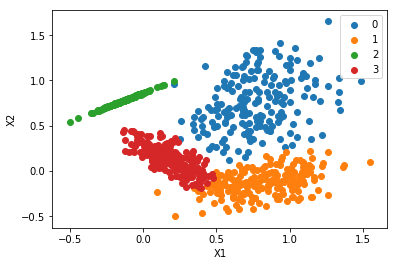

In [16]:
plot_data(X, np.argmax(r, axis=1), n_clusters)

클러스터들의 true mean, covariance와 EM 알고리즘으로 추론한 mean, covariance 값들을 비교해 봅니다.

In [17]:
print("True cluster means:")
print(true_mu_list)
print("Estimated cluster means:")
print(mu)
print("True cluster covariance matrices:")
print(true_sigma_list)
print("Estimated cluster covariance matrices:")
print(sigma)

True cluster means:
[[ 0.17390871  0.14259868]
 [-0.14099067  0.77402503]
 [ 0.8356521  -0.11299532]
 [ 0.73054665  0.7313819 ]]
Estimated cluster means:
[[ 0.7621618   0.73933708]
 [ 0.82673137 -0.11855941]
 [-0.13111202  0.780439  ]
 [ 0.17869449  0.13739632]]
True cluster covariance matrices:
[[[ 0.01689463 -0.0113129 ]
  [-0.0113129   0.01609952]]

 [[ 0.01168523  0.0073292 ]
  [ 0.0073292   0.00460398]]

 [[ 0.0625625   0.01537928]
  [ 0.01537928  0.01870041]]

 [[ 0.06705283  0.02852957]
  [ 0.02852957  0.11629321]]]
Estimated cluster covariance matrices:
[[[ 0.06125499  0.02829439]
  [ 0.02829439  0.10705266]]

 [[ 0.06001877  0.01431996]
  [ 0.01431996  0.02034532]]

 [[ 0.01073052  0.00673866]
  [ 0.00673866  0.00423961]]

 [[ 0.02082413 -0.01605015]
  [-0.01605015  0.02142641]]]


우리의 코드가 잘 동작했는지 보기 위해 Scikit-Learn에 미리 구현되어 있는 Gaussian Mixture 모델을 사용합니다.

In [18]:
gmm_model = sklearn.mixture.GaussianMixture(n_components=n_clusters,
                                            covariance_type='full',
                                            max_iter=100,
                                            n_init=1,
                                            init_params='kmeans',
                                            random_state=None,
                                            warm_start=False,
                                            verbose=0,
                                            verbose_interval=10)

In [19]:
y_prediction = gmm_model.fit_predict(X)

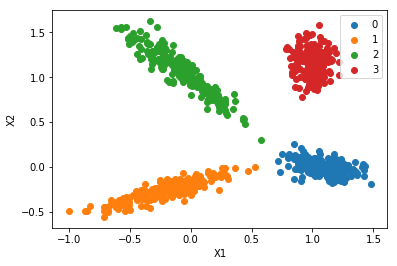

In [20]:
plot_data(X, y_prediction, n_clusters)